# `20180516a` - JSON Client - version e from un0rick

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.interpolate import griddata
import math
from scipy.signal import decimate, convolve
import json 
import re
import glob, os
import sys
import pyexiv2
import os

## Creating the set of acquisitions

In [103]:
def MetaDataImg(Modules,Experiment,Category,Description):
    Imgs = []
    for dirpath, dirnames, filenames in os.walk("."):
        for filename in [f for f in filenames if ( f.endswith(".jpg") or f.endswith(".png") )]:
            Imgs.append( os.path.join(dirpath, filename) )

    for FileName in Imgs:
        edit = 0

        metadata = pyexiv2.ImageMetadata(FileName)
        try:
            metadata.read()
        except IOError:
            print "Not an image"
        else:
            # Modules
            metadata['Exif.Image.Software'] = Modules # "matty,cletus"
            metadata['Exif.Image.Make'] = Experiment #"20180516a"
            metadata['Exif.Photo.MakerNote'] = Category #"oscilloscope"
            metadata['Exif.Image.ImageDescription'] = Description #"Unpacking data"
            metadata.write()
            
        print FileName, "done"


class us_json:
    
    IDLine = []
    TT1 = []
    TT2 = []
    tmp = [] 
    tdac = [] 
    FFT_x = [] 
    FFT_y = []
    FFT_filtered = []
    LengthT = 0
    Nacq = 0
    Raw = [] 
    Signal = []
    SignalFiltered = []
    Registers = {}
    t= []
    fPiezo = 3.5
    f = 0 # sampling freq
    firmware_md5 = ""
    experiment = ""
    Nacq = 0
    len_acq = 0
    len_line= 0
    N = 0
    V = 0
    single = 0
    processed = False
    iD =  0
    
    def JSONprocessing(self,path):
        #print("This is a message inside the class.")
        IDLine = []
        TT1 = []
        TT2 = []
        tmp = [] 
        tdac = [] 
        with open(path) as json_data:
            DATA = {}
            d = json.load(json_data)
            json_data.close()
            A = d["data"][1:] 
            print d.keys()
            if (A[0]) > 128:
                print "first"
                for i in range(len(A)/2-1):
                    value = 128*(A[2*i+0]&0b0000111) + A[2*i+1] - 512
                    IDLine.append((A[2*i+0]&0b11110000)/16) # Identify the # of the line
                    TT1.append( (A[2*i+0] & 0b00001000) / 0b1000)
                    TT2.append( (A[2*i+0] & 0b00010000) / 0b10000)
                    tmp.append( 2.0*value/512.0 ) 
            else:
                print "second"
                for i in range(len(A)/2-1):
                    value = 128*(A[2*i+1]&0b111) + A[2*i+2] - 512
                    IDLine.append((A[2*i+1]&0b11110000)/16)
                    TT1.append( (A[2*i+1] & 0b00001000) / 0b1000)
                    TT2.append( (A[2*i+1] & 0b00010000) / 0b10000)
                    tmp.append( 2.0*value/512.0 )
            self.f = float(64/((1.0+int( d["registers"]["237"] ) )))
            t = [ 1.0*x/self.f  for x in range(len(tmp))]
            self.t = t
            
            self.LengthT = len(t)
            self.FFT_x = [ X*self.f / (self.LengthT) for X in range(self.LengthT)] 
            self.FFT_y = np.fft.fft(tmp)
            self.FFT_filtered = np.fft.fft(tmp)
            
            for k in range (self.LengthT/2 + 1):
                if k < (self.LengthT * self.fPiezo * 0.5 / self.f):
                    self.FFT_filtered[k] = 0
                    self.FFT_filtered[-k] = 0
                if k > (self.LengthT * self.fPiezo *1.5 / self.f):
                    self.FFT_filtered[k] = 0
                    self.FFT_filtered[-k] = 0
                    
            self.SignalFiltered = np.real(np.fft.ifft(self.FFT_filtered))
            self.TT1 = TT1
            self.TT2 = TT2
            self.Nacq = d["registers"][str(0xEC)]
            self.len_acq = len(self.t)
            self.len_line = self.len_acq/self.Nacq
            self.Registers = d["registers"]
            
            # Precising the DAC
            REG = [int(x) for x in d["registers"].keys() if int(x) < 100]
            REG.sort() 
            dac = []
            for k in REG:
                dac.append(d["registers"][str(k)])
            # Building the DAC timeline
            tdac = []
            for pts in t[0:self.len_line]:
                i = int(pts/5.0) # time in us
                tdac.append(4.0*d["registers"][str(i+16)])

            # Updating the JSON
            self.tdac = tdac
            self.tmp = tmp
            self.single = d["registers"][str(0XEB)]
            self.t = t
            self.IDLine = IDLine
            self.firmware_md5 = d['firmware_md5']
            self.experiment = d['experiment']
            self.parameters = d['parameters']
            self.iD = d['experiment']["id"]
            self.N = d['N']
            self.V = d['V']
            self.processed = True
            
            
    def mkFFT(self):
        if self.processed:
            plt.figure(figsize=(15,5))
            plt.plot(self.FFT_x[1:self.LengthT/2], np.abs(self.FFT_y[1:self.LengthT/2]), 'b-') 
            plt.plot(self.FFT_x[1:self.LengthT/2], np.abs(self.FFT_filtered[1:self.LengthT/2]), 'y-') 
            plt.title( "FFT of "+self.iD + " - acq. #: "+ str(self.N))
            plt.xlabel('Freq (MHz)') 
            plt.tight_layout()
            FileName = "images/"+self.iD+"-"+str(self.N)+"-fft.jpg"
            plt.savefig(FileName)
            plt.show() 
            self.TagImage("matty,cletus",self.iD,"FFT","FFT of the of "+self.iD +" experiment. "+self.experiment["description"])

            
            
    def mkImg(self):
        if self.processed:
            fig, ax1 = plt.subplots(figsize=(20,10))
            ax2 = ax1.twinx() 
            ax2.plot(self.t[0:self.len_line], self.tdac[0:self.len_line], 'g-')
            ax1.plot(self.t[0:self.len_line], self.tmp[0:self.len_line], 'b-')
            plt.title( self.iD + " - acq. #: "+ str(self.N))
            ax1.set_xlabel('Time (us)')
            ax1.set_ylabel('Signal from ADC (V)', color='b')
            ax2.set_ylabel('DAC output in mV (range 0 to 1V)', color='g')
            plt.tight_layout()
            FileName = "images/"+self.iD+"-"+str(self.N)+".jpg"
            plt.savefig(FileName)
            plt.show() 
            self.TagImage("matty,cletus",self.iD,"graph","Graph of "+self.iD +" experiment. "+self.experiment["description"])

    def TagImage(self,Module,ID,Type,Description):
            ## Updating Metadata
            FileName = "images/"+self.iD+"-"+str(self.N)+".jpg"
            metadata = pyexiv2.ImageMetadata(FileName)
            try:
                metadata.read()
            except IOError:
                print "Not an image"
            else: 
                metadata['Exif.Image.Software'] = Module
                metadata['Exif.Image.Make'] = ID
                metadata['Exif.Photo.MakerNote'] = Type 
                metadata['Exif.Image.ImageDescription'] = Description 
                metadata.write()
    
                
    def SaveNPZ(self):
        NPZPath = "data/"+self.iD+"-"+str(self.N)+".npz"
        np.savez(NPZPath, self)
        print "Saved at "+NPZPath

[u'firmware_md5', u'experiment', u'parameters', u'N', u'registers', u'V', u'firmware_version', u'data']
first


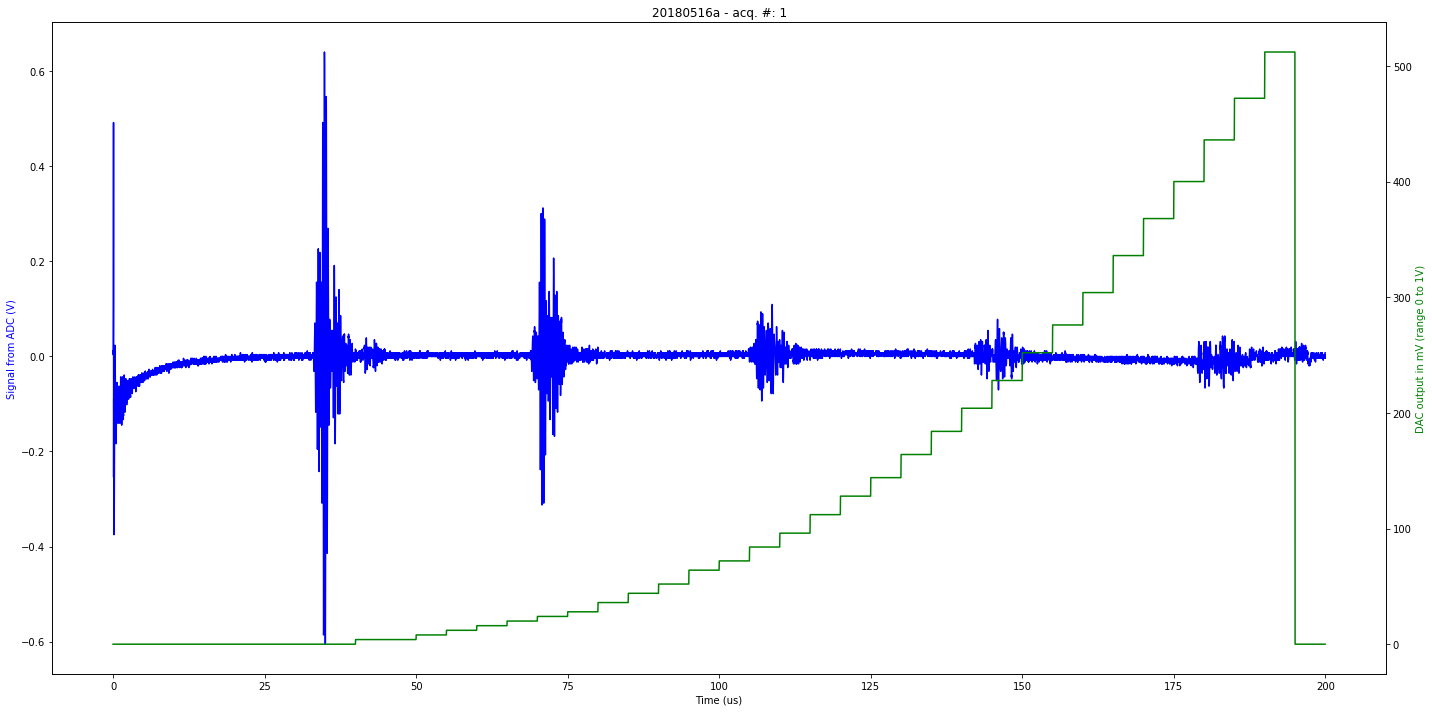

Saved at data/20180516a-1.npz


In [104]:
y = us_json()
y.JSONprocessing("data/20180516a-1.json")
y.mkImg()
y.SaveNPZ()

### Checking the effects of a FFT cleaning

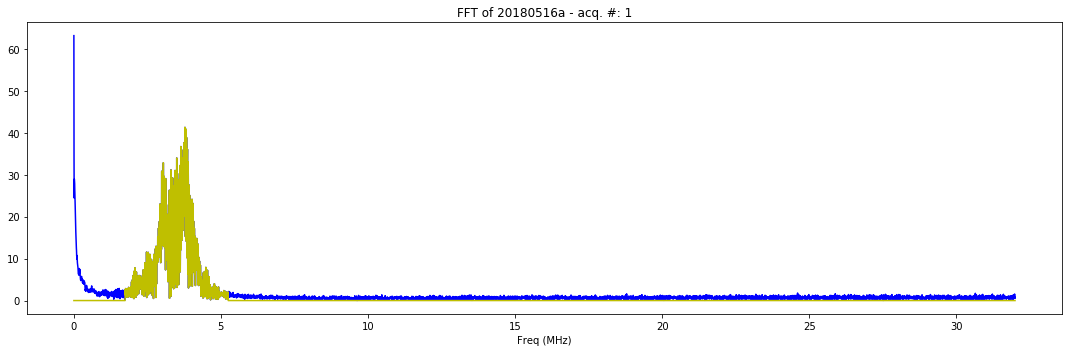

In [105]:
y.mkFFT()

### Checking the results of filtering

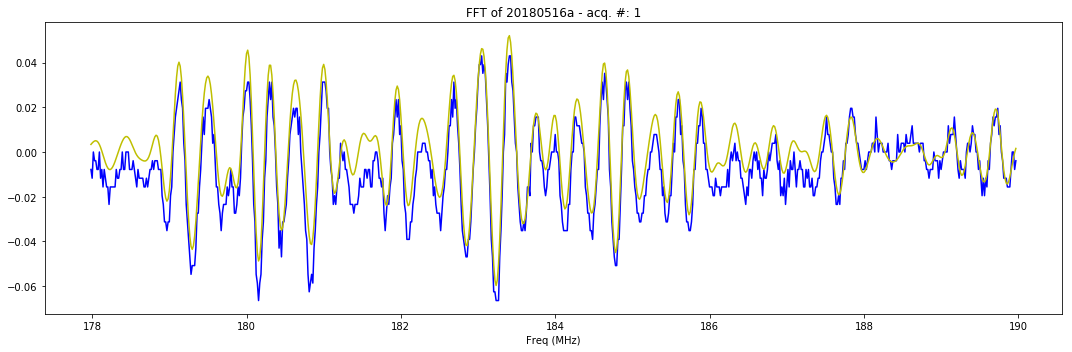

12799


In [88]:
plt.figure(figsize=(15,5))
plt.plot(y.t[12799*178/200:12799*190/200], y.tmp[12799*178/200:12799*190/200], 'b-') 
plt.plot(y.t[12799*178/200:12799*190/200], y.SignalFiltered[12799*178/200:12799*190/200], 'y-') 
plt.title( "FFT of "+y.iD + " - acq. #: "+ str(y.N))
plt.xlabel('Freq (MHz)') 
plt.tight_layout()
plt.show() 
print len(y.t)

data/20180516a-3.json
[u'firmware_md5', u'experiment', u'parameters', u'N', u'registers', u'V', u'firmware_version', u'data']
first


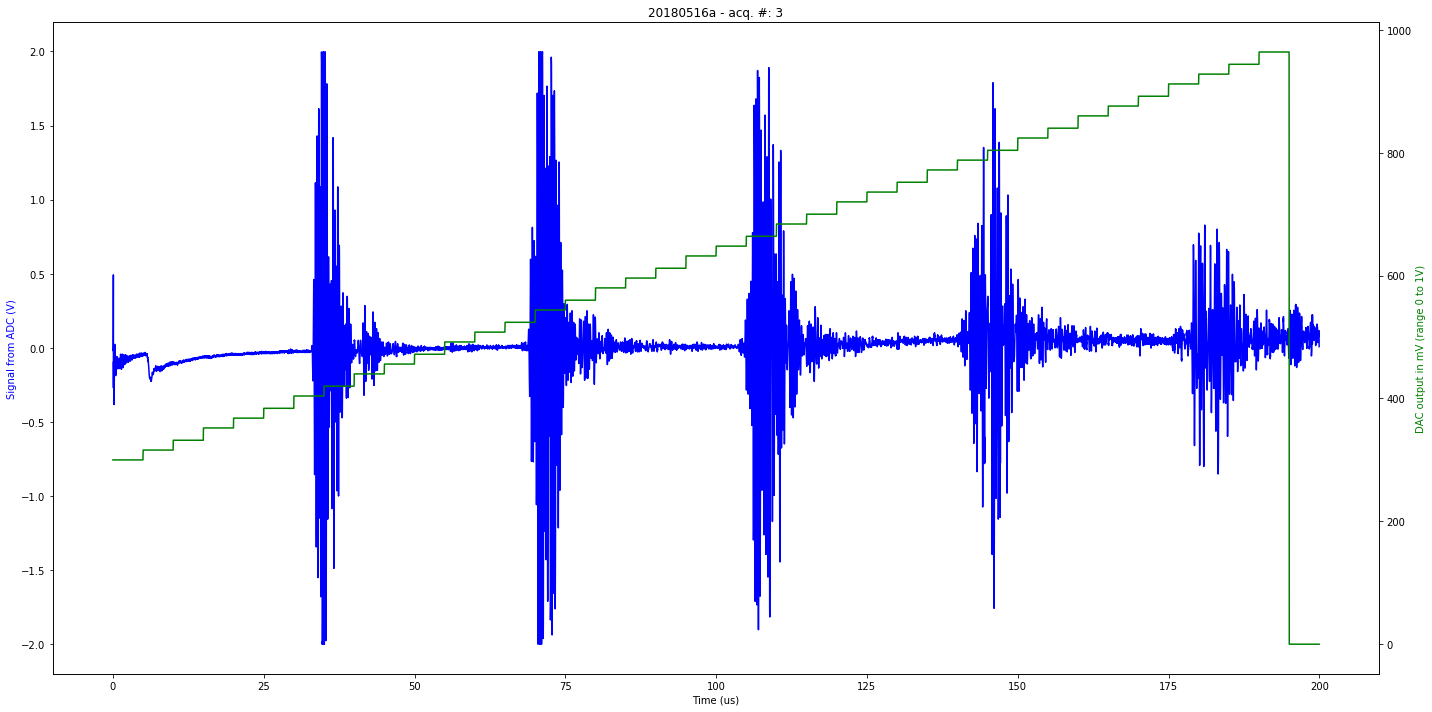

Saved at data/20180516a-3.npz
1
data/20180516a-0.json
[u'firmware_md5', u'experiment', u'parameters', u'N', u'registers', u'V', u'firmware_version', u'data']
second


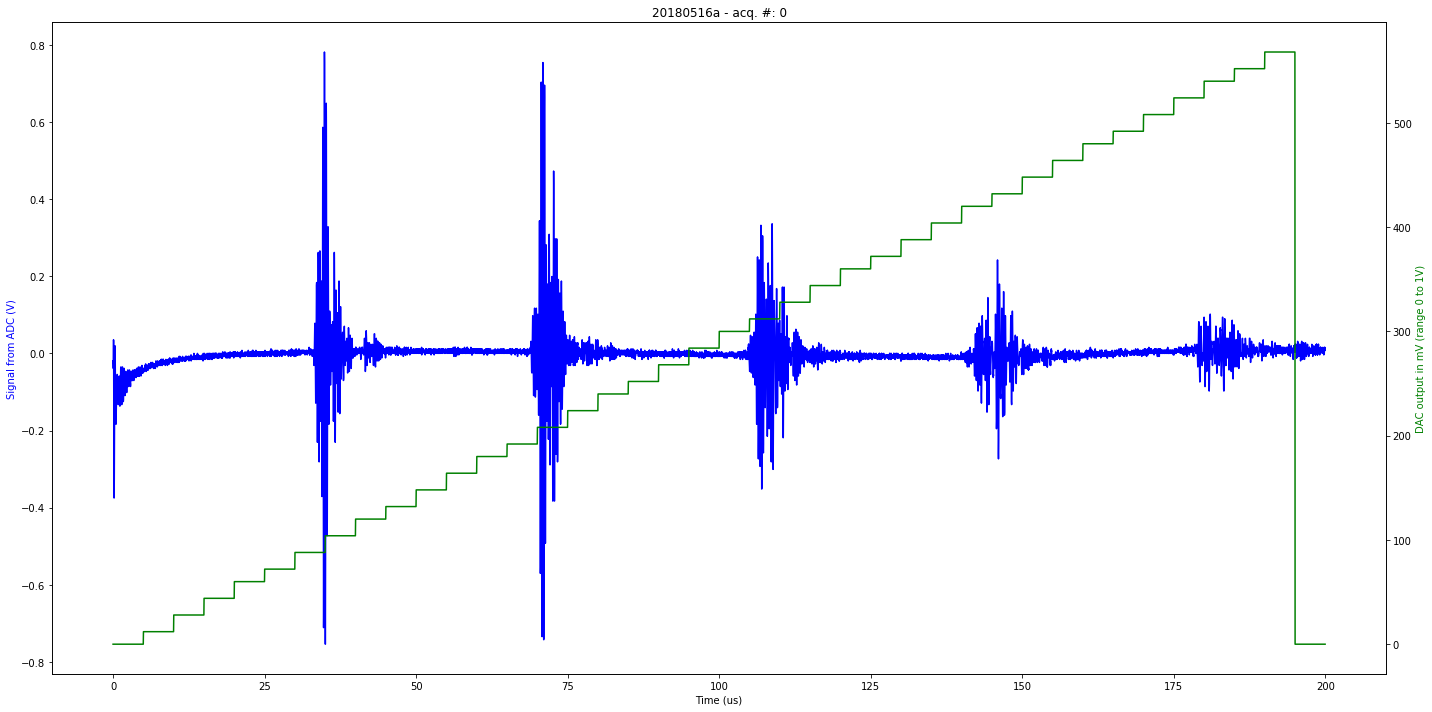

Saved at data/20180516a-0.npz
1
data/20180516a-1.json
[u'firmware_md5', u'experiment', u'parameters', u'N', u'registers', u'V', u'firmware_version', u'data']
first


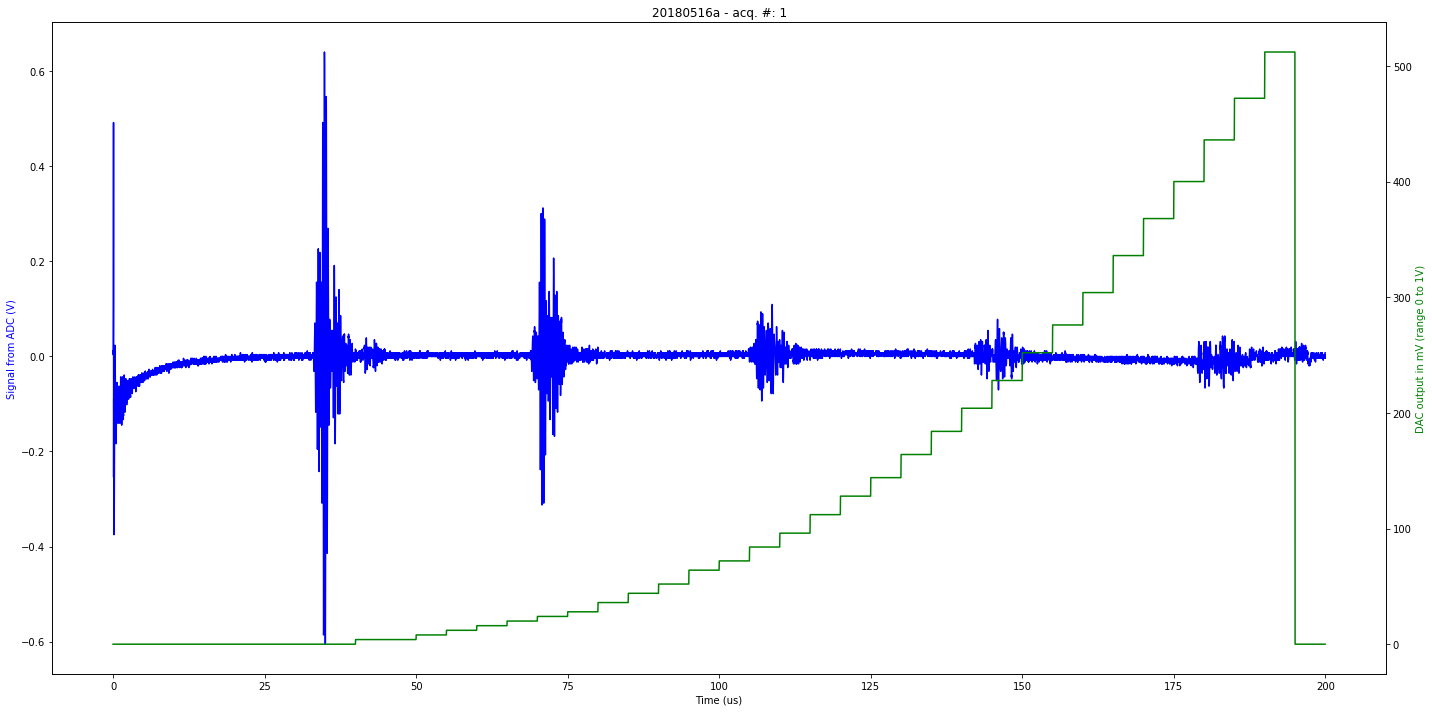

Saved at data/20180516a-1.npz
1
data/20180516a-6.json
[u'firmware_md5', u'experiment', u'parameters', u'N', u'registers', u'V', u'firmware_version', u'data']
second


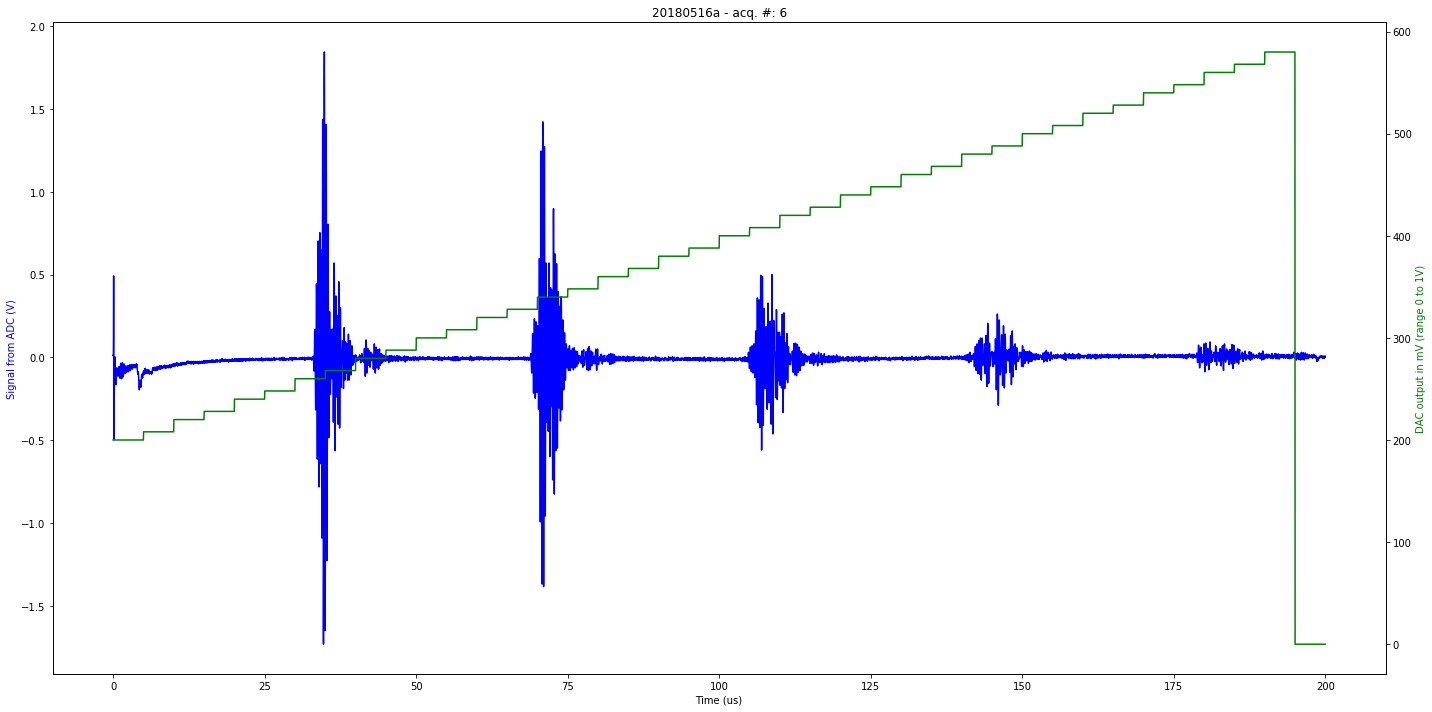

Saved at data/20180516a-6.npz
1
data/20180516a-2.json
[u'firmware_md5', u'experiment', u'parameters', u'N', u'registers', u'V', u'firmware_version', u'data']
second


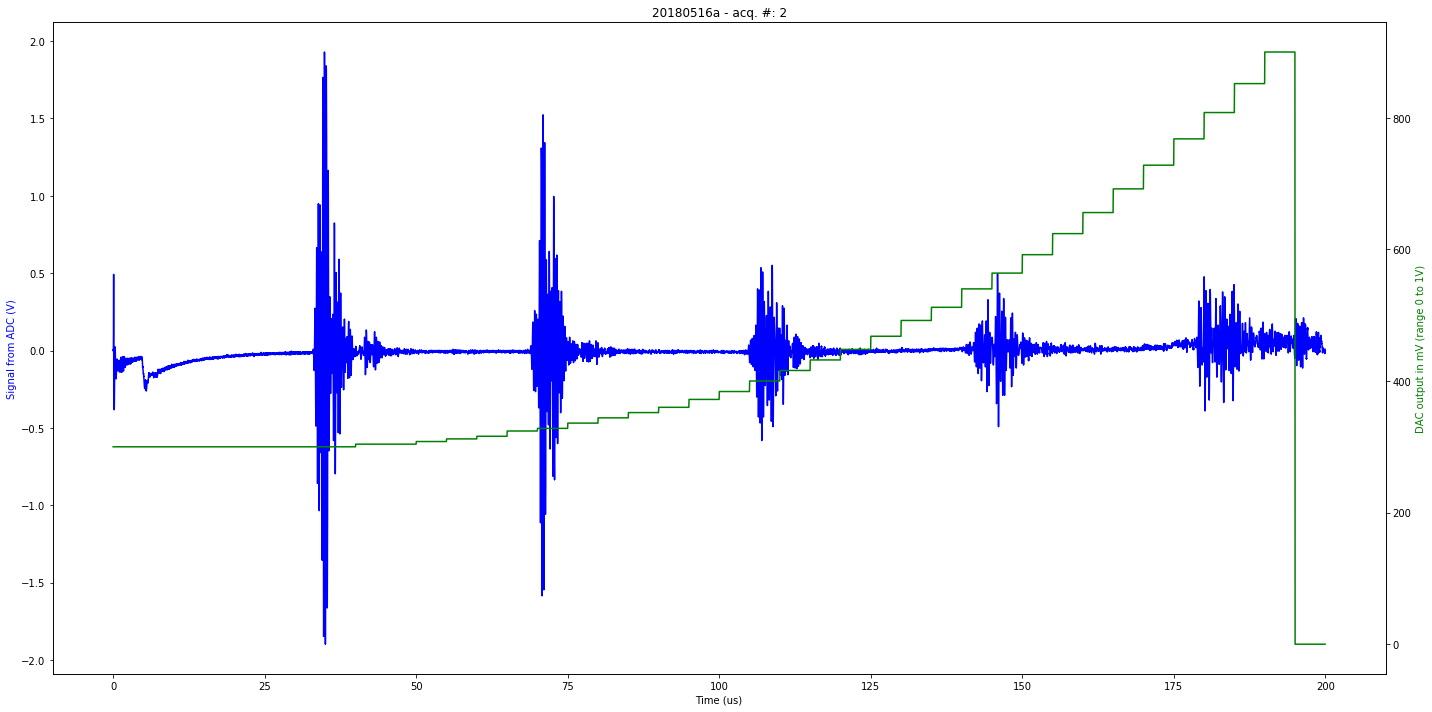

Saved at data/20180516a-2.npz
1
data/20180516a-5.json
[u'firmware_md5', u'experiment', u'parameters', u'N', u'registers', u'V', u'firmware_version', u'data']
first


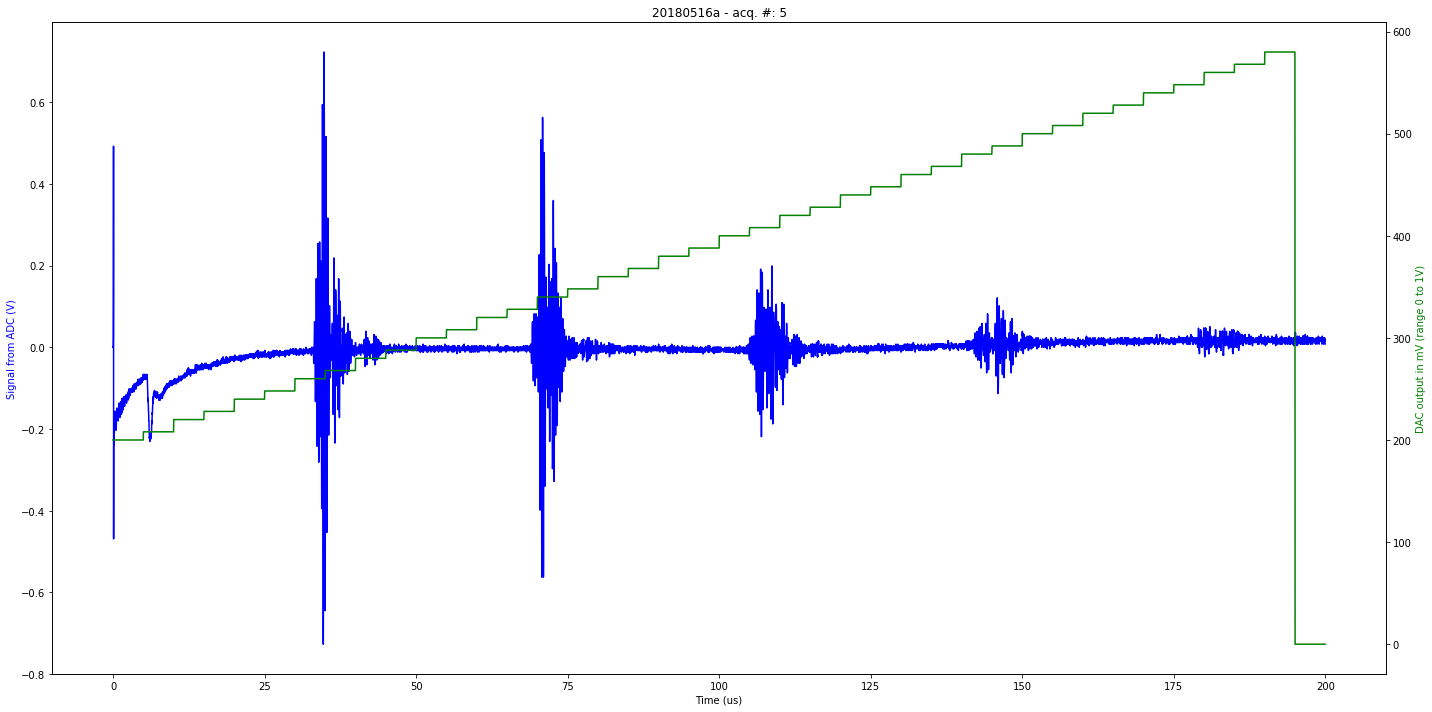

Saved at data/20180516a-5.npz
1
data/20180516a-4.json
[u'firmware_md5', u'experiment', u'parameters', u'N', u'registers', u'V', u'firmware_version', u'data']
second


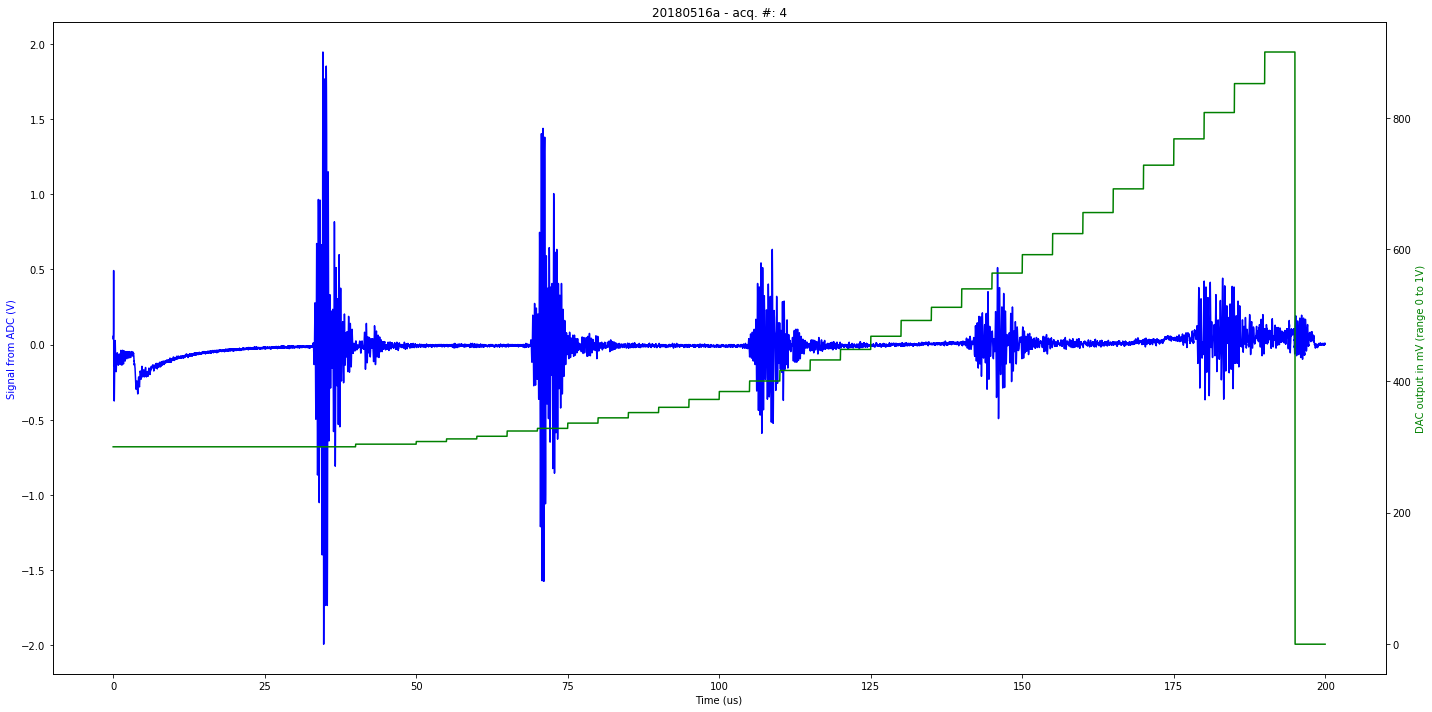

Saved at data/20180516a-4.npz
1


In [81]:
DataSet = {}

for data in glob.glob("data/*.json"):
    print data
    x = us_json()
    x.JSONprocessing(data)
    x.mkImg()
    x.SaveNPZ()
    print x.Nacq

[u'firmware_md5', u'experiment', u'parameters', u'N', u'registers', u'V', u'firmware_version', u'data']
first


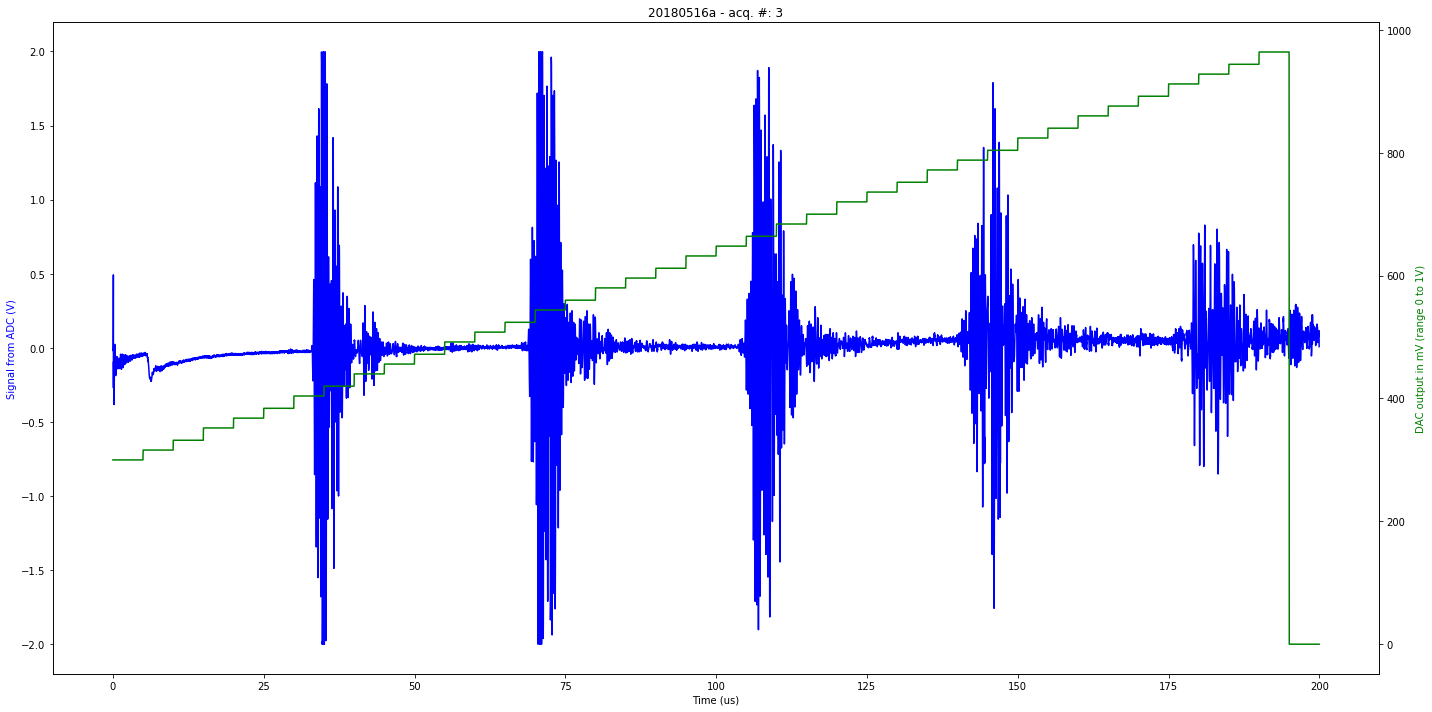

Saved at data/20180516a-3.npz


In [109]:
x = us_json()
x.JSONprocessing("data/20180516a-3.json")
x.mkImg()
x.SaveNPZ()

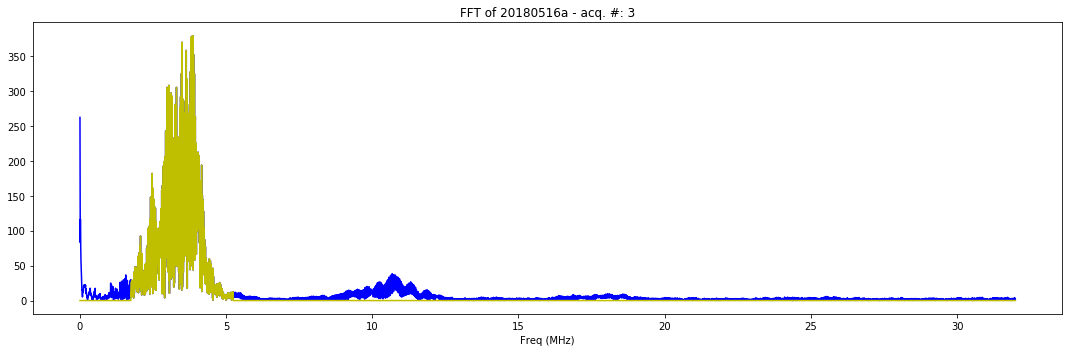

In [110]:
x.mkFFT()

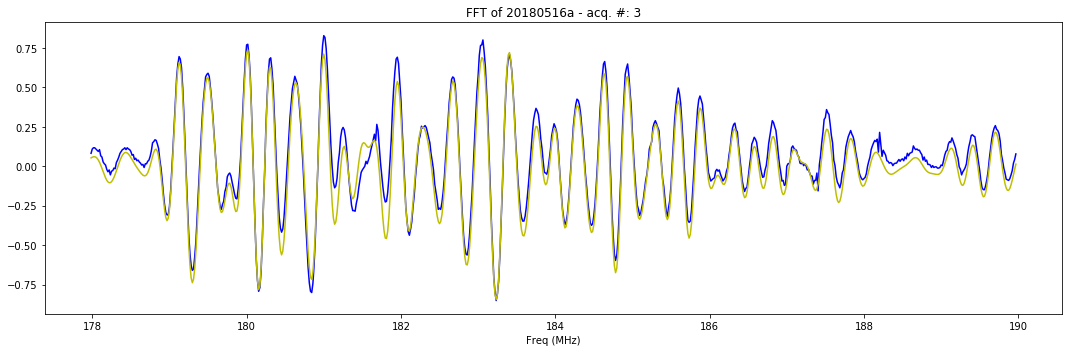

In [111]:
plt.figure(figsize=(15,5))
plt.plot(x.t[12799*178/200:12799*190/200], x.tmp[12799*178/200:12799*190/200], 'b-') 
plt.plot(x.t[12799*178/200:12799*190/200], x.SignalFiltered[12799*178/200:12799*190/200], 'y-') 
plt.title( "FFT of "+x.iD + " - acq. #: "+ str(x.N))
plt.xlabel('Freq (MHz)') 
plt.tight_layout()
plt.show() 


# Processing the data

### Checking IDLines

8 14


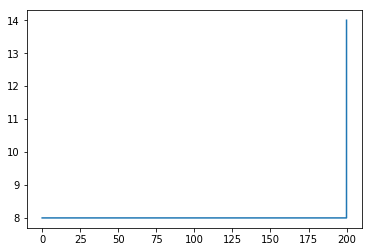

In [112]:
plt.plot(x.t,x.IDLine)
print x.IDLine[0],x.IDLine[-1]
plt.show()

In [16]:
#MetaDataImg("matty,cletus","20180516a","graph","Graphing data from 20180516a") # MetaDataImg(Modules,Experiment,Category,Description)